In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [257]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import entropy as calculate_entropy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Automatically created module for IPython interactive environment


### utilities

In [3]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))

def build_topic_word_distr(topics, word_topic_cos, words, topic_word_window_width, word_doc_frequency):
    topic_word_distr = pd.DataFrame(data=0.0, columns=topics, index=words)

    for topic in tqdm(range(len(topics))):
        word_topic_co = word_topic_cos[topic]
        word_word_co = pd.DataFrame(data=0.0, columns=word_topic_co[:topic_word_window_width].index, index=words)

        for index, (top_word, corelation) in enumerate(word_topic_co.items()):
            if index == topic_word_window_width:
                break

            word_word_frequency = corelation * word_doc_freqency[word_doc_freqency[top_word] > 0].sum(0)
            trust_factor = sigmoid((word_doc_freqency[top_word] > 0).sum(0))

            word_word_co[top_word] = (word_word_frequency * trust_factor) / word_doc_frequency
        topic_word_distr[topics[topic]] = word_word_co.max(1)
    return topic_word_distr

def infer_topic(label_classes, doc_vector, topic_word_distr):
    doc_topic_word_distr = topic_word_distr.copy()

    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_vector
    
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    return doc_topic_word_distr, doc_topic

### load dataset

In [236]:
# total number of samples needed
datasize = 300
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']
label_classes = ['autos', 'religion', 'graphics', 'space']

assert len(label_classes) == len(categories)

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [237]:
# clean out the new line characters from text in docs
def clean_doc(doc):
    ''' remove unwanter characters line new line '''

    unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
    doc = doc.lower()
    for unwanted_chr in unwanted_chrs:
        doc = doc.replace(unwanted_chr, ' ')

    return doc.strip()

In [238]:
labels = []
clean_docs = []
max_document_length = None

# the new classes
sizes = [0] * len(label_classes)
assert len(label_classes) == len(sizes)

for index, doc in enumerate(docs):
    if len(clean_docs) == datasize*len(label_classes):
        break
        
    cd = clean_doc(doc)
    
    if len(cd) == 0 or cd.isspace() or (max_document_length is not None and len(cd) <= max_document_length):
        continue
        
    label_class = classes[old_labels[index]]
    label = categories.index(label_class)

    if sizes[label] < datasize:
        clean_docs.append(cd)
        labels.append(label)

        sizes[label] += 1

labels = np.array(labels)
print(clean_docs[0])

<apparently you re not a woman - my husband hates the auto door locks <feels safer in a car that locks easily  in addition to watching around <in a secluded spot, etc - have my keys ready to open the door so i m


In [239]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes: {label_classes} of size min:{min(sizes)}, max:{max(sizes)}")

there are 1200 docs and 4 classes: ['autos', 'religion', 'graphics', 'space'] of size min:300, max:300


### count words

In [240]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)
count_vectorizer.fit(train_docs)
vocabulary = count_vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 17523


### Prepare Datatset

In [241]:
# create doc count vectors
train_doc_vectors = count_vectorizer.transform(train_docs).toarray()
# train_doc_vectors = (train_doc_vectors > 0).astype(float)
train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)

test_doc_vectors = count_vectorizer.transform(test_docs).toarray()
# test_doc_vectors = (test_doc_vectors > 0).astype(float)
test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

804 train_docs, 396 test docs


In [242]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (804, 17524)


In [243]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1200 docs and 4 classes


In [244]:
document_word_frequency.head()

,00,000,0000,00000,0001,000100255pixel,00041032,0004136,0004246,0004422,...,zullen,zulu,zurbrin,zurvanism,zwaartepunten,zwak,zwakke,zware,zwarte,__labels__
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000119,0.000596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Prepare Binary Dataset

In [245]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = document_word_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

### Topic and word corelation

In [246]:
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=vocabulary)

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid((word_doc_freqency > 0).sum(0))
    
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_total_frequency).fillna(0)

topic_word_distr = topic_word_distr.T
entropy = np.nan_to_num(calculate_entropy(topic_word_distr, base=2))
topic_word_distr = (topic_word_distr * (np.e**(-entropy**2))).T
print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (17523, 4)


In [247]:
topic_word_distr.head()

,autos,religion,graphics,space
00,0.021364,0.001354,0.102974,0.037267
000,0.107895,0.008882,0.020714,0.019123
0000,0.000000,0.000000,0.000000,0.880797
00000,0.000000,0.000000,0.000000,0.880797
0001,0.000000,0.731059,0.000000,0.000000


In [248]:
label_classes

['autos', 'religion', 'graphics', 'space']

In [249]:
label_class = 'graphics'
topic_word_distr[label_class][topic_word_distr[label_class] > 0].sort_values(ascending=False)

3d             1.000000
vga            0.999999
animation      0.999998
formats        0.999994
programming    0.999994
                 ...   
man            0.000142
government     0.000138
down           0.000129
speak          0.000128
stop           0.000116
Name: graphics, Length: 6721, dtype: float64

In [250]:
word="computer"
topic_word_distr.loc[word].sort_values(ascending=False)

graphics    0.178895
autos       0.043989
space       0.031708
religion    0.000000
Name: computer, dtype: float64

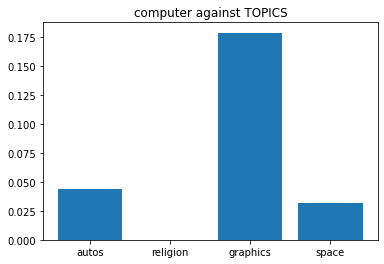

In [251]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr.loc[word].index, topic_word_distr.loc[word])
plt.show()

### Evaluate Topic model with Train set

In [258]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...



==> train-accuracy is 99.50%, 4 misclassified



### Evaluating Topic Model with test set

In [259]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

Evaluating Topic Model...



==> test-accuracy is 82.32%, avg-accuarcy = 90.91%, 70 misclassified



### Investigating Misclassification

In [260]:
training = True
tlabels = train_labels if training else test_labels
tdoc_vectors = train_doc_vectors if training else test_doc_vectors
misclassified = misclassified_train if training else misclassified_test

for doc_index in tqdm(misclassified):
    doc_vector = tdoc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    
    xv = doc_topic_word_distr.iloc[np.where(doc_topic_word_distr.sum(1) > 0)]
    print(xv.loc[xv.sum(1).sort_values(ascending=False).index])
    print(train_docs[doc_index])
    print(f"predicted_topic = {doc_topic}, actual_topic = {label_classes[tlabels[doc_index]]} \n")

                 autos  religion  graphics     space
nasa          0.000000  0.000000  0.003257  0.019943
akron         0.000000  0.000000  0.019113  0.000000
composites    0.000000  0.000000  0.014334  0.000000
modeling      0.000000  0.000000  0.012714  0.000155
workstations  0.000000  0.000000  0.012837  0.000000
...                ...       ...       ...       ...
with          0.000037  0.000038  0.000039  0.000022
is            0.000028  0.000040  0.000030  0.000030
it            0.000038  0.000026  0.000031  0.000031
in            0.000035  0.000032  0.000027  0.000029
one           0.000031  0.000034  0.000028  0.000028

[107 rows x 4 columns]
sampe, ncga, the university of akron, and nasa lewis research center is sponsoring:                        computers and composites   a one-day seminar devoted to practical applications of  computer workstations for efficient processing, design, and    manufacture of composites  may 18, 1993 at  the university of akron   akron, ohio  spea

In [261]:
xv = train_doc_vectors[:, vocabulary.index("enough")]
xv[xv.argsort()[::-1]][:20]

array([0.07142857, 0.03947368, 0.03225806, 0.03125   , 0.02702703,
       0.02631579, 0.02325581, 0.02173913, 0.0212766 , 0.02040816,
       0.02      , 0.01587302, 0.01515152, 0.01492537, 0.01428571,
       0.01204819, 0.01176471, 0.0106383 , 0.01052632, 0.00877193])

In [256]:
for index in xv.argsort()[::-1][:20]:
    print(train_docs[index], '====>', label_classes[train_labels[index]])
    print()

usually....go enough places and you ll see stuff happen you didn t think did. ====> autos

depends. if you assume the existance of a working ssto like dc, on billion $$ would be enough to put about a quarter million pounds of stuff on the moon. if some of that mass went to send equipment to make lox for the transfer vehicle, you could send a lot more. either way, its a lot more than needed.  this prize isn t big enough to warrent developing a ssto, but it is enough to do it if the vehicle exists.    allen ====> space

where does the shadow come from?  there s nothing close enough to block sunlight from hitting them.  i wouldn t expect there to be anything block our view of them either.  what am i missing? ====> space

if raw materials where to cost enough that getting them from space would be cost effective then the entire world economy would colapse long before the space mines could be built.    allen ====> space

recently-manufactured locomotives have wheel-slip detection systems tha

In [116]:
xv.argsort()[::-1][20]

342